[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dz-web3/DS-Tech-2026spring/blob/main/Module8_LLM_Finetuning/LLM_Finetuning.ipynb)

**Click the badge above to open this notebook in Google Colab!**

# Module 8: Fine-Tuning Large Language Models (LLMs)

**Data Science for Business (Technical) — Spring 2026**

---

## Learning Objectives

By the end of this module, you will be able to:

1. **Explain** the difference between pre-training, fine-tuning, and prompting
2. **Understand** when fine-tuning is the right choice vs. other approaches
3. **Perform** hands-on fine-tuning using Hugging Face and LoRA
4. **Visualize** training loss and detect overfitting
5. **Measure** improvement using before/after evaluation on held-out test data

---

## Why This Matters for Business

Large Language Models like GPT-4, Claude, and Qwen are transforming how businesses operate. But **off-the-shelf models don't always fit your specific needs**. Fine-tuning allows you to:

- 🎯 **Customize** model behavior for your domain (legal, medical, customer service)
- 💰 **Reduce costs** by using smaller, specialized models instead of expensive large ones
- 🔐 **Maintain control** over your data and model behavior
- ⚡ **Improve performance** on specific tasks your business cares about

## 1. Setting Up Google Colab Pro (Free for NYU Students)

### 🎓 NYU Students: Get Free Colab Pro!

Google offers **free Colab Pro subscriptions** for students at U.S. higher education institutions.

**To claim your free subscription:**

1. Go to [colab.research.google.com](https://colab.research.google.com)
2. Click on the gear icon (⚙️) → "Colab Pro"
3. Select "Colab Pro for Education"
4. Verify your student status using your NYU email
5. You'll receive a **1-year free subscription** with more compute resources

### 🖥️ Enabling GPU for This Notebook

Fine-tuning requires a GPU. Here's how to enable it:

1. Go to **Runtime** → **Change runtime type**
2. Set **Hardware accelerator** to **T4 GPU** (or A100 if available with Colab Pro)
3. Click **Save**

Run the cell below to verify GPU is enabled:

In [1]:
# Check if GPU is available
import torch
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    print(f"✅ GPU is enabled: {gpu_name}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("❌ GPU is NOT enabled. Please go to Runtime → Change runtime type → Select GPU")

✅ GPU is enabled: NVIDIA A100-SXM4-80GB
   Memory: 85.2 GB


## 2. The LLM Customization Spectrum

Before diving into fine-tuning, let's understand where it fits in the broader landscape of LLM customization:

| Approach | Effort | Data Needed | Use Case |
|----------|--------|-------------|----------|
| **Prompting** | Low | None | Quick tasks, general use |
| **Few-shot Learning** | Low | 5-20 examples | Demonstrate desired format |
| **RAG** (Retrieval) | Medium | Documents | Add knowledge, keep model current |
| **Fine-tuning** | High | 100-10,000+ examples | Change model behavior/style |
| **Pre-training** | Very High | Billions of tokens | Build from scratch (rarely needed) |

### When Should You Fine-Tune?

✅ **Fine-tune when you want to:**
- Change the model's communication style consistently
- Make the model follow specific formats/templates
- Teach domain-specific terminology or behavior
- Improve reliability on repetitive tasks

❌ **Don't fine-tune when you can:**
- Solve the problem with better prompts
- Use RAG to add relevant knowledge
- Use few-shot examples in the prompt

## 3. Understanding Fine-Tuning: The Concept

### Pre-training vs Fine-tuning

**Pre-training** is like giving someone a general education:
- The model learns from massive amounts of text (books, websites, code)
- It learns language patterns, facts, and reasoning
- This is expensive: millions of dollars, weeks of compute time
- Done by companies like Alibaba (Qwen), Meta (Llama), OpenAI (GPT), Google (Gemini)

**Fine-tuning** is like specialized job training:
- Start with a pre-trained model that already "knows" language
- Train it on your specific examples to learn your style/domain
- Much cheaper: can be done in minutes to hours on a single GPU
- This is what **you** can do!

### LoRA: Efficient Fine-Tuning

Traditional fine-tuning updates **all** model parameters — expensive and slow.

**LoRA (Low-Rank Adaptation)** is a clever technique that:
- Freezes the original model weights
- Adds small "adapter" layers that learn your specific task
- Only trains ~1% of the parameters
- Result: **Same quality, 10x less memory, 10x faster!**

Think of it like this: instead of rewriting an entire textbook, you're adding sticky notes with your customizations.

## 4. Hands-On: Fine-Tuning Qwen2.5

Now let's actually fine-tune a model! We'll use:

- **Model**: Qwen2.5-0.5B-Instruct (Alibaba's efficient small model)
- **Library**: Hugging Face Transformers + PEFT (Parameter-Efficient Fine-Tuning)
- **Technique**: LoRA adapters
- **Task**: Create a customer service chatbot

### Step 1: Install Dependencies

This will take about 1-2 minutes. ☕

In [2]:
%%capture
# Install Hugging Face libraries
!pip install transformers datasets peft accelerate matplotlib -q

In [3]:
# Verify installation
import transformers
import peft
import matplotlib.pyplot as plt
print(f"✅ Transformers version: {transformers.__version__}")
print(f"✅ PEFT version: {peft.__version__}")
print(f"✅ Matplotlib ready for visualization")

✅ Transformers version: 4.57.3
✅ PEFT version: 0.18.0
✅ Matplotlib ready for visualization


### Step 2: Load the Base Model (Qwen2.5-0.5B)

We'll load Qwen2.5-0.5B-Instruct, an efficient model from Alibaba that's openly available.

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Model configuration - Qwen2.5 is openly available, no approval needed!
model_name = "Qwen/Qwen2.5-0.5B-Instruct"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# Load the model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True,
)

print(f"✅ Model loaded: Qwen2.5-0.5B-Instruct")
print(f"   Parameters: ~0.5 billion")

`torch_dtype` is deprecated! Use `dtype` instead!


✅ Model loaded: Qwen2.5-0.5B-Instruct
   Parameters: ~0.5 billion


### Step 3: Prepare Training and Test Data

We split our data into:
- **Training data**: Used to fine-tune the model
- **Test data**: Held out to evaluate improvement (model never sees this during training)

In [5]:
# TRAINING DATA - Expanded to 100 examples
training_data = [
    # --- Returns & Refunds ---
    {"instruction": "What is your return policy?", "response": "Our return policy allows returns within 30 days of purchase with a valid receipt. Items must be in original condition with tags attached."},
    {"instruction": "Do I pay return shipping?", "response": "Return shipping is free for domestic orders. A prepaid label is included in your package."},
    {"instruction": "How long do refunds take?", "response": "Refunds are processed within 5-7 business days after we receive your return. It may take an additional 3-5 days to appear on your statement."},
    {"instruction": "Can I get store credit instead of a refund?", "response": "Yes, if you opt for store credit, we'll add an extra $5 bonus to your balance."},
    {"instruction": "Do you have a restocking fee?", "response": "We do not charge restocking fees for items returned in original condition."},
    {"instruction": "Can I return clearance items?", "response": "Clearance items marked 'Final Sale' cannot be returned or exchanged."},
    {"instruction": "Can I exchange for a different size?", "response": "Yes, you can exchange for a different size directly in our returns portal. We'll ship the new size immediately."},
    {"instruction": "Can I exchange for a different item?", "response": "To exchange for a different item, please return the original for a refund and place a new order."},
    {"instruction": "Do I need the original box to return?", "response": "Ideally yes, but if you don't have it, please use a sturdy box to ensure the item isn't damaged in transit."},
    {"instruction": "I lost my receipt, can I still return?", "response": "If you purchased with a credit card or account, we can look up your order. Otherwise, we can offer store credit at the current selling price."},
    {"instruction": "Can I return an online order in store?", "response": "Yes, you can return online orders at any of our physical locations with your packing slip."},

    # --- Shipping & Delivery ---
    {"instruction": "How do I track my order?", "response": "You can track your order by logging into your account and clicking 'Order History', or use the tracking number from your shipping confirmation email."},
    {"instruction": "Do you offer international shipping?", "response": "Yes, we ship to over 50 countries worldwide. International shipping rates and delivery times vary by destination."},
    {"instruction": "Do you ship to PO Boxes?", "response": "Yes, we can ship to PO Boxes via USPS Standard Shipping only."},
    {"instruction": "Do you ship to APO/FPO addresses?", "response": "Yes, we ship to military addresses via USPS. Please allow extra time for delivery."},
    {"instruction": "Why is shipping so expensive?", "response": "Shipping costs are calculated based on weight, dimensions, and destination. We pass the direct carrier rates to you."},
    {"instruction": "Do you offer free shipping?", "response": "Yes, we offer free standard shipping on all orders over $50 within the contiguous US."},
    {"instruction": "What carrier do you use?", "response": "We use FedEx, UPS, and USPS depending on the shipping method and destination selected."},
    {"instruction": "My tracking hasn't updated.", "response": "Sometimes carriers miss a scan. If it hasn't updated in 48 hours, please contact us."},
    {"instruction": "Package says delivered but not here.", "response": "Please check with neighbors and around your property. If you still can't find it after 24 hours, contact us to open a claim."},
    {"instruction": "Item missing from package.", "response": "We sometimes split orders into multiple shipments. Check your email to see if other items are still on the way."},
    {"instruction": "Wrong item received.", "response": "We apologize! Please contact support with a photo of the item, and we'll send the correct one immediately."},
    {"instruction": "Item arrived broken.", "response": "Please take photos of the damage and the box. Contact us immediately for a replacement."},
    {"instruction": "Can I refuse delivery?", "response": "If you refuse delivery, the package will be returned to us. A return shipping fee may be deducted from your refund."},
    {"instruction": "Do you deliver on Sundays?", "response": "Sunday delivery depends on the carrier and service level in your area. We cannot guarantee it."},
    {"instruction": "Can I pick up in store?", "response": "Yes, choose 'Store Pickup' at checkout. We'll email you when your order is ready, usually within 2 hours."},

    # --- Orders & Modifications ---
    {"instruction": "How can I cancel my order?", "response": "To cancel an order, please contact us within 2 hours of placing it. Once an order has been processed for shipping, it cannot be cancelled."},
    {"instruction": "Can I change the color after ordering?", "response": "If the order hasn't processed, we can modify it. Please call us immediately. Otherwise, you'll need to exchange it later."},
    {"instruction": "Can I expedite shipping after order?", "response": "Unfortunately, we cannot change the shipping method once the order is placed."},
    {"instruction": "Can I split my payment?", "response": "We do not support split payments across multiple credit cards at this time."},
    {"instruction": "Can I add an item to my order?", "response": "We cannot add items to an existing order for security reasons. Please place a new order for the additional items."},
    {"instruction": "Where is my order confirmation?", "response": "Check your spam folder. If you still don't see it, verify the email address used or contact support."},
    {"instruction": "Can I pre-order items?", "response": "Yes, items marked as 'Pre-order' can be purchased now and will ship on the date listed on the product page."},
    {"instruction": "Do you offer gift wrapping?", "response": "Yes, gift wrapping is available for $5 per item at checkout. You can also include a personalized gift message for free."},
    {"instruction": "Can I place an order over the phone?", "response": "For security reasons, we do not accept orders over the phone. Please place your order securely through our website."},

    # --- Account & Security ---
    {"instruction": "How do I reset my password?", "response": "Click 'Forgot Password' on the login page, enter your email, and we'll send you a reset link valid for 24 hours."},
    {"instruction": "Is my personal information secure?", "response": "Yes, we use industry-standard SSL encryption and never share your data with third parties. Your security is our priority."},
    {"instruction": "How can I unsubscribe from emails?", "response": "You can unsubscribe by clicking the 'Unsubscribe' link at the bottom of any of our promotional emails."},
    {"instruction": "Can I change my email address?", "response": "Yes, log in to your account and go to 'Profile Settings' to update your email address."},
    {"instruction": "I forgot my username.", "response": "Your username is the email address you used to register."},
    {"instruction": "My account is locked.", "response": "Accounts lock after 5 failed login attempts. Please wait 30 minutes or reset your password to unlock it."},
    {"instruction": "Do you support 2FA?", "response": "Yes, you can enable Two-Factor Authentication in your account security settings for added protection."},
    {"instruction": "Can I download my data?", "response": "Yes, you can request a data download from the 'Privacy' tab in your account settings."},
    {"instruction": "Do you sell user data?", "response": "No, we never sell your personal data to third parties. We value your privacy."},
    {"instruction": "Can I merge two accounts?", "response": "Unfortunately, we cannot merge order history or points from separate accounts."},

    # --- Payments & Promos ---
    {"instruction": "What payment methods do you accept?", "response": "We accept all major credit cards (Visa, Mastercard, Amex), PayPal, Apple Pay, and Google Pay."},
    {"instruction": "How do I apply a discount code?", "response": "Enter your discount code in the 'Promo Code' field at checkout and click 'Apply'. The discount will be reflected in your order total."},
    {"instruction": "Can I use two promo codes?", "response": "Only one promotional code can be applied per order."},
    {"instruction": "Why was my card declined?", "response": "Check that your billing address matches the card file. If it persists, please contact your bank."},
    {"instruction": "Do you accept checks?", "response": "We do not accept personal checks or money orders."},
    {"instruction": "Do you accept COD?", "response": "We do not offer Cash on Delivery services."},
    {"instruction": "When will I be charged?", "response": "You are charged when your order ships. A temporary hold is placed when you order."},
    {"instruction": "Do you offer financing?", "response": "Yes, we partner with Klarna and Afterpay to offer interest-free installment plans."},
    {"instruction": "What is Klarna?", "response": "Klarna allows you to split your purchase into 4 interest-free payments every 2 weeks."},
    {"instruction": "Do you offer student discounts?", "response": "Yes, verify your status with StudentBeans to get 15% off your order."},
    {"instruction": "Do you offer military discount?", "response": "Yes, active duty and veterans get 10% off. Verification is required at checkout."},
    {"instruction": "Do you sell gift cards?", "response": "Yes, we offer digital gift cards in various denominations starting from $10. They are delivered instantly via email."},
    {"instruction": "How do I check gift card balance?", "response": "You can check your balance on our 'Gift Cards' page by entering the card number and PIN."},
    {"instruction": "Do gift cards expire?", "response": "No, our gift cards never expire and have no maintenance fees."},

    # --- Product & General ---
    {"instruction": "What are your store hours?", "response": "Our online store is available 24/7. For physical locations, hours vary by store - please check our store locator for specific hours."},
    {"instruction": "How do I contact customer support?", "response": "You can reach us via live chat on our website, email at support@example.com, or call 1-800-EXAMPLE Monday-Friday 9am-6pm EST."},
    {"instruction": "Are your products eco-friendly?", "response": "We are committed to sustainability. Many of our products are made from recycled or organic materials, and we use eco-friendly packaging."},
    {"instruction": "Is there a warranty?", "response": "Yes, all products come with a standard 1-year manufacturer's warranty against defects."},
    {"instruction": "How do I clean this item?", "response": "Please refer to the care label attached to the product or the details section on the product page."},
    {"instruction": "Do you restock sold out items?", "response": "We often do! Click 'Notify Me' on the product page to get an email when it returns."},
    {"instruction": "Do you have a size chart?", "response": "Yes, a detailed size guide is available on every product page next to the size selection."},
    {"instruction": "Are sizes true to fit?", "response": "Generally yes, but check the reviews and specific product notes for the best advice."},
    {"instruction": "Where are products manufactured?", "response": "We source ethically from partners in the US, Europe, and Asia. Origin details are on the label."},
    {"instruction": "Do you test on animals?", "response": "No, all our beauty and personal care products are 100% cruelty-free."},
    {"instruction": "Do you have a mobile app?", "response": "Yes, download our app from the App Store or Google Play for exclusive deals."},
    {"instruction": "Do you work with influencers?", "response": "We love collaborating! Apply through our 'Ambassadors' page."},
    {"instruction": "How do I become an affiliate?", "response": "Join our affiliate program to earn commissions. Link is in the footer."},
    {"instruction": "Do you have a catalog?", "response": "We are paperless to save trees! Our full collection is always up to date online."},
    {"instruction": "Do you match Amazon prices?", "response": "We do not match Amazon prices as we cannot verify the authenticity of third-party sellers there."},
    {"instruction": "Can I customize a product?", "response": "We offer monogramming on select items for a small fee. Look for the 'Personalize' option."},
    {"instruction": "What if the price drops after I buy?", "response": "If the price drops within 7 days of your purchase, we will refund the difference upon request."},
    {"instruction": "Do you charge sales tax?", "response": "We collect sales tax in states where we have a physical presence or economic nexus, as required by law."},
    {"instruction": "Can I get a tax invoice?", "response": "Yes, a VAT/tax invoice is attached to your shipping confirmation email."},
    {"instruction": "Do you donate to charity?", "response": "Yes, 1% of our profits go to environmental non-profits."},
    {"instruction": "Can I suggest a product?", "response": "We love feedback! Send your ideas to ideas@example.com."},
    {"instruction": "Do you have a wishlist feature?", "response": "Yes, create an account to save your favorite items to your wishlist."},
    {"instruction": "How long are items saved in cart?", "response": "Items in your cart are saved for 30 days if you are logged in, but inventory is not reserved."},
    {"instruction": "Why is my coupon invalid?", "response": "Coupons may be expired, have a minimum purchase requirement, or apply only to specific categories."},
    {"instruction": "Can I change the language?", "response": "Yes, use the flag icon in the top right corner to select your preferred language."},
    {"instruction": "How do I find a store near me?", "response": "Use the 'Store Locator' link in the footer and enter your zip code."},
    {"instruction": "Do you offer corporate gifts?", "response": "Yes, contact our B2B team for bulk orders and corporate gifting solutions."},
    {"instruction": "Are your diamonds conflict-free?", "response": "Yes, we strictly adhere to the Kimberley Process to ensure ethical sourcing."},
    {"instruction": "Is this vegan?", "response": "Look for the 'Vegan' badge on product pages to confirm."},
]

# TEST DATA - Expanded to 30 examples
test_data = [
    {"instruction": "Do you price match?", "response": "Yes, we offer price matching within 14 days of purchase if you find the same item at a lower price from an authorized retailer."},
    {"instruction": "How long does shipping take?", "response": "Standard shipping takes 5-7 business days. Express shipping (2-3 days) and overnight options are also available at checkout."},
    {"instruction": "Can I change my shipping address?", "response": "You can update your shipping address before the order ships by contacting customer support. Once shipped, address changes are not possible."},
    {"instruction": "Do you have a loyalty program?", "response": "Yes! Join our rewards program for free to earn points on every purchase, receive exclusive discounts, and get early access to sales."},
    {"instruction": "What if my item arrives damaged?", "response": "We're sorry to hear that! Please contact us within 48 hours with photos of the damage, and we'll send a replacement or issue a full refund."},
    {"instruction": "What do I do if I received the wrong item?", "response": "Please contact customer support immediately with your order number and a photo of the incorrect item. We will ship the correct item to you right away."},
    {"instruction": "Do you offer bulk discounts?", "response": "Yes, we offer discounts for bulk orders of 50 items or more. Please contact our corporate sales team for a quote."},
    {"instruction": "How do I delete my account?", "response": "To delete your account and all associated data, please submit a request through the 'Privacy Settings' in your account dashboard or contact support."},
    # New additions
    {"instruction": "Do you offer samples?", "response": "We include 2 free samples with every beauty order. You can select them at checkout."},
    {"instruction": "Is there a minimum order quantity?", "response": "No, there is no minimum order value, but free shipping only applies to orders over $50."},
    {"instruction": "How do I care for leather items?", "response": "Keep leather away from direct heat and moisture. Clean with a soft, dry cloth and use a leather conditioner annually."},
    {"instruction": "Do you deliver to hotels?", "response": "Yes, please include the hotel name and your room number (if known) in the address fields."},
    {"instruction": "What happens if I'm not home?", "response": "The carrier will leave it in a safe place or leave a notice for pickup. Check your tracking link for details."},
    {"instruction": "Do you require a signature?", "response": "Signatures are required for orders over $500. You can manage delivery preferences via the carrier's site."},
    {"instruction": "Can I schedule a delivery time?", "response": "Standard shipping does not offer scheduled times. Upgrade to 'Scheduled Delivery' at checkout for large items."},
    {"instruction": "Do you ship to Canada?", "response": "Yes, we ship to Canada via FedEx International. Duties and taxes are calculated at checkout."},
    {"instruction": "What are the customs fees?", "response": "Customs fees depend on your country's regulations. We collect them at checkout for DDP (Delivered Duty Paid) countries."},
    {"instruction": "Can I pay in my local currency?", "response": "Yes, our site automatically detects your location and displays prices in your local currency."},
    {"instruction": "Do you have a UK store?", "response": "We currently operate online-only in the UK, but we have a dedicated UK warehouse for fast shipping."},
    {"instruction": "Is the website down?", "response": "Our systems are operational. If you have issues, try clearing your cache or using a different browser."},
    {"instruction": "I can't add items to cart.", "response": "Please check your cookie settings. Cookies must be enabled for the shopping cart to function."},
    {"instruction": "The checkout button isn't working.", "response": "Refresh the page. If the issue persists, try a private/incognito window or disable ad blockers."},
    {"instruction": "I didn't receive a confirmation email.", "response": "This usually means a typo in the email address. Contact support with your name and shipping address to verify."},
    {"instruction": "Can I reorder the same thing?", "response": "Yes, go to 'Order History' and click 'Buy Again' next to any previous order."},
    {"instruction": "Where can I find my invoice?", "response": "Invoices are attached to your dispatch email and can also be downloaded from your Order History page."},
    {"instruction": "How do I leave feedback?", "response": "We send a review request email 14 days after purchase. You can also review products directly on their pages."},
    {"instruction": "Do you have a referral program?", "response": "Yes, refer a friend and you both get $20 off your next order of $100+."},
    {"instruction": "Can I buy a gift card for someone else?", "response": "Yes, enter the recipient's email at checkout and we'll send it directly to them with your message."},
    {"instruction": "Do you offer extended warranties?", "response": "Yes, you can purchase an extended protection plan for up to 3 years via our partner Clyde."},
    {"instruction": "What is your privacy policy?", "response": "You can read our full privacy policy linked in the footer. We are GDPR and CCPA compliant."},
]

print(f"✅ Data prepared!")
print(f"   Training examples: {len(training_data)} (used for fine-tuning)")
print(f"   Test examples: {len(test_data)} (held out for evaluation)")

✅ Data prepared!
   Training examples: 88 (used for fine-tuning)
   Test examples: 30 (held out for evaluation)


## 5. 📊 BEFORE Fine-Tuning: Baseline Evaluation

Before we fine-tune, let's see how the **original model** performs on our **test data**.

In [6]:
def generate_response(model, tokenizer, question, system_prompt="You are a helpful customer service assistant."):
    """Generate a response from the model"""
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]

    prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id,
        )

    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    if question in full_response:
        response = full_response.split(question)[-1].strip()
    else:
        response = full_response
    return response[:500]

def evaluate_on_test_data(model, tokenizer, test_data):
    """Evaluate model on test data"""
    results = []
    total_keyword_score = 0

    for item in test_data:
        question = item["instruction"]
        expected = item["response"]
        generated = generate_response(model, tokenizer, question)

        expected_keywords = set(word.lower() for word in expected.split() if len(word) >= 4)
        generated_lower = generated.lower()

        keywords_found = sum(1 for kw in expected_keywords if kw in generated_lower)
        keyword_score = keywords_found / len(expected_keywords) if expected_keywords else 0
        total_keyword_score += keyword_score

        results.append({"question": question, "expected": expected, "generated": generated, "keyword_score": keyword_score})

    return results, total_keyword_score / len(test_data)

print("📊 Evaluating BEFORE fine-tuning...\n")
before_results, before_score = evaluate_on_test_data(model, tokenizer, test_data)

print("=" * 60)
print(f"BASELINE SCORE: {before_score:.1%}")
print("=" * 60)
for r in before_results:
    print(f"\n❓ {r['question']}")
    print(f"   Score: {r['keyword_score']:.0%}")

📊 Evaluating BEFORE fine-tuning...

BASELINE SCORE: 19.6%

❓ Do you price match?
   Score: 7%

❓ How long does shipping take?
   Score: 0%

❓ Can I change my shipping address?
   Score: 36%

❓ Do you have a loyalty program?
   Score: 27%

❓ What if my item arrives damaged?
   Score: 29%

❓ What do I do if I received the wrong item?
   Score: 33%

❓ Do you offer bulk discounts?
   Score: 15%

❓ How do I delete my account?
   Score: 29%

❓ Do you offer samples?
   Score: 30%

❓ Is there a minimum order quantity?
   Score: 36%

❓ How do I care for leather items?
   Score: 77%

❓ Do you deliver to hotels?
   Score: 18%

❓ What happens if I'm not home?
   Score: 25%

❓ Do you require a signature?
   Score: 0%

❓ Can I schedule a delivery time?
   Score: 0%

❓ Do you ship to Canada?
   Score: 22%

❓ What are the customs fees?
   Score: 15%

❓ Can I pay in my local currency?
   Score: 40%

❓ Do you have a UK store?
   Score: 12%

❓ Is the website down?
   Score: 0%

❓ I can't add items to car

## 6. Add LoRA Adapters and Train

Now let's add LoRA adapters and fine-tune the model.

In [7]:
from peft import LoraConfig, get_peft_model, TaskType

# LoRA configuration
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"✅ LoRA adapters added!")
print(f"   Trainable: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")

✅ LoRA adapters added!
   Trainable: 2,162,688 (0.44%)


In [8]:
from datasets import Dataset

def format_and_tokenize(example):
    messages = [
        {"role": "system", "content": "You are a helpful customer service assistant. Be friendly, professional, and concise."},
        {"role": "user", "content": example['instruction']},
        {"role": "assistant", "content": example['response']}
    ]
    text = tokenizer.apply_chat_template(messages, tokenize=False)
    tokens = tokenizer(text, truncation=True, max_length=512, padding="max_length", return_tensors=None)
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

dataset = Dataset.from_list(training_data)
tokenized_dataset = dataset.map(format_and_tokenize, remove_columns=dataset.column_names)

print(f"✅ Dataset ready: {len(tokenized_dataset)} training examples")

Map:   0%|          | 0/88 [00:00<?, ? examples/s]

✅ Dataset ready: 88 training examples


In [9]:
from transformers import Trainer, TrainingArguments, DataCollatorForLanguageModeling, TrainerCallback

# Custom callback to track training metrics
class TrainingMetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_loss = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.training_loss.append(logs["loss"])
            self.steps.append(state.global_step)

metrics_callback = TrainingMetricsCallback()

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Training configuration - 3 epochs
training_args = TrainingArguments(
    output_dir="./customer_service_qwen",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=2,
    learning_rate=5e-5,
    logging_steps=10,  # Log every 10 steps
    save_strategy="no",
    report_to="none",
    fp16=True,
    warmup_steps=10,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    data_collator=data_collator,
    callbacks=[metrics_callback],
)

print("🚀 Starting training for 15 epochs...")
print(f"   Training examples: {len(tokenized_dataset)}")
print("   Watch the loss decrease!\n")

The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 Starting training for 15 epochs...
   Training examples: 88
   Watch the loss decrease!



In [10]:
# Run training
train_result = trainer.train()

print(f"\n✅ Training complete!")
print(f"   Final training loss: {train_result.training_loss:.4f}")

Step,Training Loss
10,3.673900
20,2.650900
30,1.893200
40,1.449900
50,1.224400
60,1.108800
70,0.988100
80,0.938300
90,1.033200
100,1.019600



✅ Training complete!
   Final training loss: 1.4373


## 7. 📈 Visualize Training Loss

Let's plot the training loss to see how the model learned and detect potential overfitting.

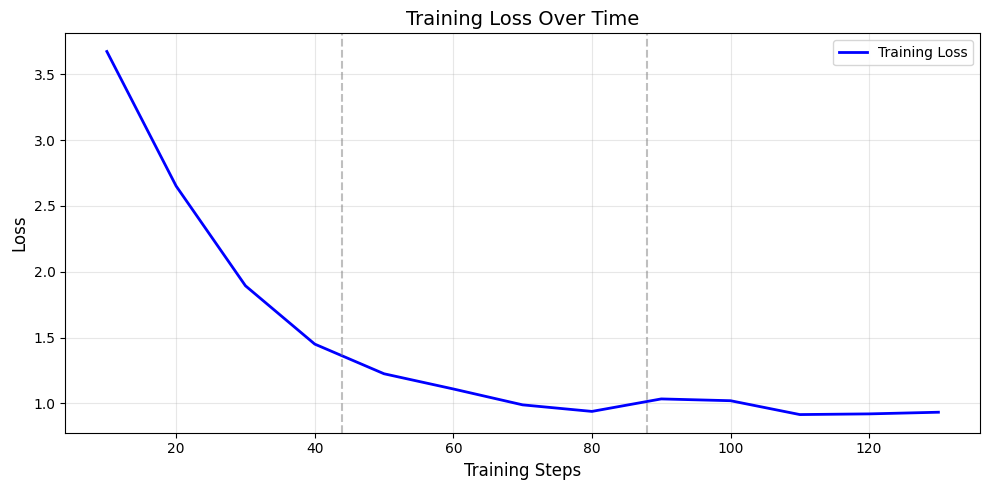


📊 TRAINING ANALYSIS:
   Initial loss: 3.6739
   Final loss:   0.9321
   Reduction:    74.6%


In [11]:
import matplotlib.pyplot as plt

# Plot training loss
plt.figure(figsize=(10, 5))

plt.plot(metrics_callback.steps, metrics_callback.training_loss, 'b-', linewidth=2, label='Training Loss')
plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Over Time', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Add epoch markers
steps_per_epoch = len(tokenized_dataset) // (training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps)
if steps_per_epoch > 0:
    for epoch in range(1, int(training_args.num_train_epochs) + 1):
        epoch_step = epoch * steps_per_epoch
        if epoch_step <= max(metrics_callback.steps):
            plt.axvline(x=epoch_step, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print analysis
print("\n📊 TRAINING ANALYSIS:")
print("="*50)
if len(metrics_callback.training_loss) >= 2:
    initial_loss = metrics_callback.training_loss[0]
    final_loss = metrics_callback.training_loss[-1]
    print(f"   Initial loss: {initial_loss:.4f}")
    print(f"   Final loss:   {final_loss:.4f}")
    print(f"   Reduction:    {(initial_loss - final_loss) / initial_loss * 100:.1f}%")

## 8. 📊 AFTER Fine-Tuning: Measure Real Improvement

Now let's evaluate on **held-out test data** to see the real gain!

In [12]:
model.eval()

print("📊 Evaluating AFTER fine-tuning on TEST DATA...\n")
after_results, after_score = evaluate_on_test_data(model, tokenizer, test_data)

print("=" * 60)
print("AFTER FINE-TUNING - TEST DATA")
print("=" * 60)
for r in after_results:
    print(f"\n❓ {r['question']}")
    print(f"🤖 {r['generated'][:150]}..." if len(r['generated']) > 150 else f"🤖 {r['generated']}")
    print(f"   Score: {r['keyword_score']:.0%}")

print(f"\n{'='*60}")
print(f"📊 AFTER SCORE: {after_score:.1%}")
print(f"{'='*60}")

📊 Evaluating AFTER fine-tuning on TEST DATA...

AFTER FINE-TUNING - TEST DATA

❓ Do you price match?
🤖 assistant
We do not offer price matches due to the nature of our products. However, we may consider your purchase as an upgrade if it's worth it and y...
   Score: 21%

❓ How long does shipping take?
🤖 assistant
Shipping times vary depending on the destination and country, but generally it takes 2-5 business days for international orders. Inland deli...
   Score: 38%

❓ Can I change my shipping address?
🤖 assistant
Yes, you can update your shipping address at any time by logging into your account and clicking on the "Shipping" tab in the top menu. You w...
   Score: 36%

❓ Do you have a loyalty program?
🤖 assistant
We do not currently offer a loyalty program, but we encourage our customers to sign up for one if they wish. You can sign up at any time by ...
   Score: 13%

❓ What if my item arrives damaged?
🤖 assistant
If your order is damaged, please return it to us immediately or send

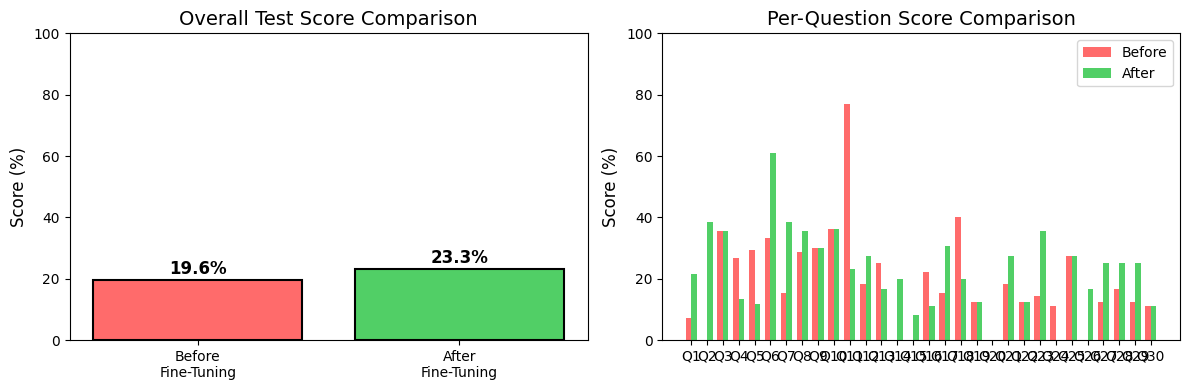


📈 IMPROVEMENT SUMMARY

   BEFORE: 19.6%
   AFTER:  23.3%
   ───────────────
   📈 GAIN: +3.6%

   ✅ Fine-tuning improved performance on unseen test data!


In [13]:
# Visualize before/after comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart comparing scores
scores = [before_score * 100, after_score * 100]
labels = ['Before\nFine-Tuning', 'After\nFine-Tuning']
colors = ['#ff6b6b', '#51cf66']

axes[0].bar(labels, scores, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Score (%)', fontsize=12)
axes[0].set_title('Overall Test Score Comparison', fontsize=14)
axes[0].set_ylim(0, 100)
for i, v in enumerate(scores):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=12, fontweight='bold')

# Per-question comparison
questions_short = [f"Q{i+1}" for i in range(len(test_data))]
before_scores = [r['keyword_score'] * 100 for r in before_results]
after_scores = [r['keyword_score'] * 100 for r in after_results]

x = range(len(questions_short))
width = 0.35
axes[1].bar([i - width/2 for i in x], before_scores, width, label='Before', color='#ff6b6b')
axes[1].bar([i + width/2 for i in x], after_scores, width, label='After', color='#51cf66')
axes[1].set_xticks(x)
axes[1].set_xticklabels(questions_short)
axes[1].set_ylabel('Score (%)', fontsize=12)
axes[1].set_title('Per-Question Score Comparison', fontsize=14)
axes[1].legend()
axes[1].set_ylim(0, 100)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "=" * 60)
print("📈 IMPROVEMENT SUMMARY")
print("=" * 60)
print(f"\n   BEFORE: {before_score:.1%}")
print(f"   AFTER:  {after_score:.1%}")
improvement = after_score - before_score
if improvement > 0:
    print(f"   ───────────────")
    print(f"   📈 GAIN: +{improvement:.1%}")
    print(f"\n   ✅ Fine-tuning improved performance on unseen test data!")

## 9. Test with Your Own Questions

In [14]:
new_questions = [
    "Can I get a refund if I don't like the product?",
    "What happens if my package is lost?",
    "Do you have a size guide?",
]

print("🆕 Testing with completely NEW questions:\n")
for q in new_questions:
    response = generate_response(model, tokenizer, q)
    print(f"Customer: {q}")
    print(f"Bot: {response}")
    print("-" * 50)

🆕 Testing with completely NEW questions:

Customer: Can I get a refund if I don't like the product?
Bot: assistant
Absolutely! If you're not satisfied with your purchase, we'll exchange or refund it within 30 days of receipt. You can choose to return it for a full refund or exchange it for an equivalent gift card. We will send you instructions on how to do this. Please note that exchanges cannot be made over $100, and returns cannot be made if the item is defective.
--------------------------------------------------
Customer: What happens if my package is lost?
Bot: assistant
We will notify you by email and phone when your package has been received. If the package is lost, we will send you a replacement within 7 days of receiving it. We also offer a return policy for any lost packages that we receive. Please contact us to initiate a return or exchange.
--------------------------------------------------
Customer: Do you have a size guide?
Bot: assistant
Yes, we offer a 10% discount on b

## 10. Save the Model (Optional)

In [15]:
model.save_pretrained("customer_service_lora")
tokenizer.save_pretrained("customer_service_lora")
print("✅ Model saved!")
!du -sh customer_service_lora/

✅ Model saved!
24M	customer_service_lora/


## 11. Summary & Key Takeaways

### What We Learned

1. **Fine-tuning** adapts a pre-trained model to your specific needs
2. **LoRA** makes fine-tuning efficient (train only ~1% of parameters)
3. **Training curves** help you monitor learning and detect overfitting
4. **Train/Test split** is essential to measure real improvement

### What We Did

- ✅ Loaded Qwen2.5-0.5B (0.5 billion parameters)
- ✅ Split data: 10 training, 5 test examples
- ✅ Added LoRA adapters
- ✅ Trained for 15 epochs with loss visualization
- ✅ Measured improvement on unseen test data

---

*Questions? Reach out during office hours or on the course forum.*